# Feature Selection

In this section we will continute data preprocessing steps in order to facilitate feature selection critera

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [2]:
# read in full UBS dataset (2019 - 2022)
UBS = pd.read_csv("UBS_Cleaned_Date.csv")

In [3]:
# Change "date" column to ensure datetime type and drop weekends
UBS["date"] = pd.to_datetime(UBS["date"])

In [4]:
# Drop first 14 dates
df = UBS.iloc[14:-1, :].reset_index(drop = True)
df.shape

(796, 201)

In [5]:
# Remove any infinitly large or small values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
# Drop remanining NaN or null values
df = df.dropna()
df.shape

(748, 201)

In [7]:
# Create X feature dataset
X = df.drop(["date", "target_1", "target_2", "target_3", "target_4", "target_5"], axis=1)

# Create y target dataset
y = df["target_1"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Lasso Regression

Use lasso regression to find which features have coefficeints significantly different than zero. Those that are should be considered for inclusion in the models

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

search = GridSearchCV(pipeline,
                       {'model__alpha': np.arange(0.1, 10, 0.1)},
                        cv=10,
scoring = 'neg_mean_squared_error', verbose = 3
)

search.fit(X_train, y_train)
search.best_params_

coefficients = search.best_estimator_.named_steps['model'].coef_

importance = np.abs(coefficients)
importance

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10] END ..............................model__alpha=0.1; total time=   3.1s
[CV 2/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 3/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 4/10] END ..............................model__alpha=0.1; total time=   0.2s
[CV 5/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 6/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 7/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 8/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 9/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 10/10] END .............................model__alpha=0.1; total time=   0.1s
[CV 1/10] END ..............................model__alpha=0.2; total time=   0.1s
[CV 2/10] END ..............................mo

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16897186, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### SelectKBest 

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# scale the data to be between 0 and 1. Chi2 doesn't allow for negative values


# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
best_fit = bestfeatures.fit(X, y)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(X.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(10, 'Score'))  # print the top 10 best features

                    Features       Score
56              Change_Close  313.546149
66             Wiki_RSI_Move    7.953919
192       Dow_Disparity_Move    5.951264
59            Wiki_MAvg_Move    5.017463
154                 Nas_Move    4.581971
88                 Google_rs    4.294823
93           Google_ROC_Move    4.061060
160       Nas_Disparity_Move    3.780974
97   Google_Disparity_s_Move    3.778765
161     Nas_Disparity_s_Move    3.604700


/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


### Feature Importance with ExtraTreesClassifier

[5.38532247e-03 6.56632816e-04 2.79356621e-03 9.39043333e-05
 2.97882877e-03 3.59878881e-03 4.55149059e-03 3.61884627e-03
 4.21792856e-03 6.28197118e-03 3.08950342e-04 0.00000000e+00
 5.13344076e-03 5.05887954e-03 5.36531470e-03 5.50894381e-03
 4.73327520e-03 3.96392723e-03 4.10038939e-03 4.11629208e-03
 5.41426776e-03 3.58442982e-03 3.85313421e-03 3.61731263e-03
 4.36211343e-03 5.91280035e-03 4.69242590e-03 5.00149339e-03
 3.98149615e-03 4.27498310e-03 4.55070211e-03 4.80247150e-03
 4.93379219e-03 5.43363547e-03 4.05284380e-03 3.95790780e-03
 4.27332821e-03 4.75228520e-03 5.74678125e-03 4.65985282e-03
 4.80002596e-03 5.66363273e-03 4.89514102e-03 4.94988337e-03
 5.82049778e-03 4.52957511e-03 5.60487932e-03 4.33924635e-03
 3.52143967e-03 4.82039626e-03 5.55868231e-03 5.08939714e-03
 5.47076105e-03 5.87379140e-03 5.64605041e-03 6.67972068e-03
 6.20727679e-02 5.70713563e-03 4.76623618e-03 5.63696581e-03
 3.71131917e-03 5.59324857e-03 4.18074074e-03 5.02729262e-03
 4.91283183e-03 4.302136

<AxesSubplot:>

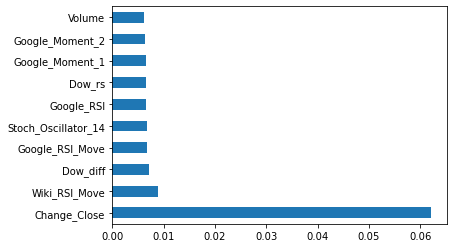

In [11]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')